In [28]:
#import packages
import numpy as np
import pandas as pd

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('./Datasets/ICICIBANK.csv')

#print the head
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,ICICIBANK,EQ,69.20,74.35,74.75,71.40,74.75,74.75,73.20,286260,2.095439e+12,NaN,NaN,NaN
1,2000-01-04,ICICIBANK,EQ,74.75,73.05,78.50,71.00,73.25,73.05,73.38,296264,2.173893e+12,NaN,NaN,NaN
2,2000-01-05,ICICIBANK,EQ,73.05,70.00,73.50,67.50,70.00,69.50,70.85,227624,1.612794e+12,NaN,NaN,NaN
3,2000-01-06,ICICIBANK,EQ,69.50,71.00,74.00,69.55,69.75,70.05,72.04,275149,1.982121e+12,NaN,NaN,NaN
4,2000-01-07,ICICIBANK,EQ,70.05,69.00,72.50,66.00,67.00,67.40,68.72,138809,9.538882e+11,NaN,NaN,NaN


In [29]:
df1 = df.reset_index()['Close']

In [30]:
df1.shape

(5097,)

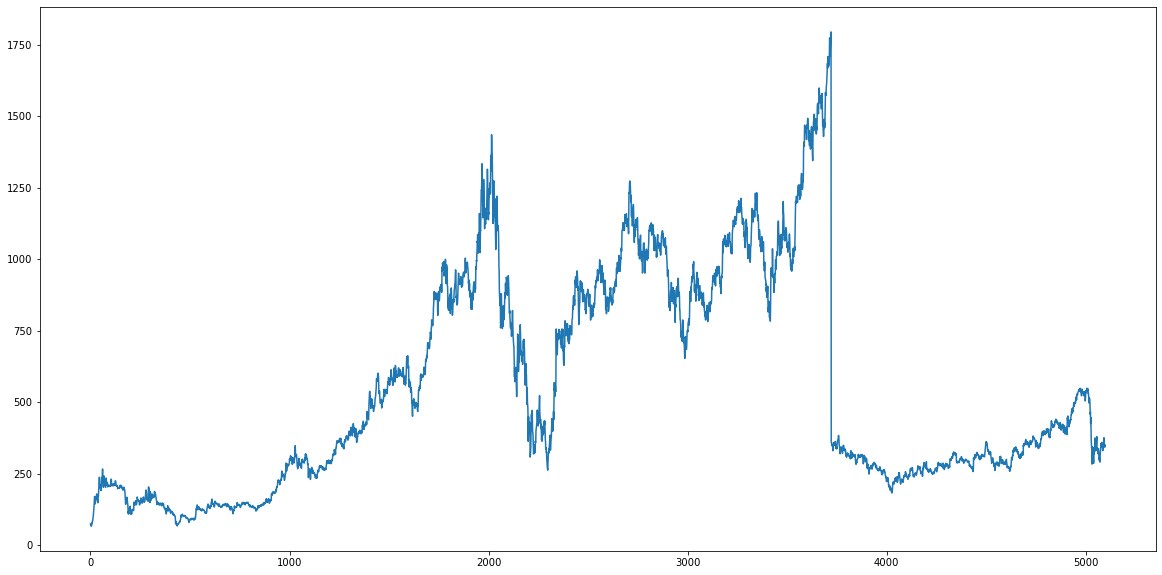

In [31]:
# Plotting the dataframe
plt.plot(df1)

In [32]:
df1= scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [33]:
df1

array([[0.00425667],
       [0.00327214],
       [0.00121619],
       ...,
       [0.16314357],
       [0.15966873],
       [0.16450455]])

In [34]:
df1.shape

(5097, 1)

In [52]:
# SPLITTING INTO TRAIN AND TEST
#deciding the split size
trainSize = int(len(df1)*0.65)
testSize= len(df1)- trainSize

#Making the splits
trainData, testData = df1[0:trainSize, :],df1[trainSize:len(df1), :1 ] 

In [53]:
len(trainData), len(testData)


(3313, 1784)

In [55]:
# Converting the array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY= [],[]
    for i in range(len(dataset)-time_step-1):
        a= dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [56]:
time_step= 320
X_train, Y_train= create_dataset(trainData, time_step)
X_test, Y_test= create_dataset(testData, time_step)

In [57]:
print(X_train.shape)

(2992, 320)


In [58]:
print(Y_train.shape)

(2992,)


In [59]:
#Before going into LSTM, we have to make our data 3D
X_train= X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test= X_test.reshape(X_test.shape[0], X_test.shape[1],1)


In [42]:
#Creating the stacked LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [60]:

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(320,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [61]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 320, 50)           10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 320, 50)           20200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.fit(X_train, Y_train, validation_data= (X_test, Y_test), epochs= 15, batch_size=128, verbose=1)

Train on 2992 samples, validate on 1463 samples
Epoch 1/10
2992/2992 [==============================] - 512s 171ms/sample - loss: 3.3187e-04 - val_loss: 7.5782e-05
Epoch 2/10
2992/2992 [==============================] - 331s 111ms/sample - loss: 3.0824e-04 - val_loss: 8.0194e-05
Epoch 3/10
2992/2992 [==============================] - 440s 147ms/sample - loss: 2.7685e-04 - val_loss: 7.7013e-05
Epoch 4/10
2992/2992 [==============================] - 377s 126ms/sample - loss: 2.6530e-04 - val_loss: 8.8299e-05
Epoch 5/10
2992/2992 [==============================] - 406s 136ms/sample - loss: 2.6621e-04 - val_loss: 6.9328e-05
Epoch 6/10
2992/2992 [==============================] - 397s 133ms/sample - loss: 2.4403e-04 - val_loss: 7.7441e-05
Epoch 7/10
2992/2992 [==============================] - 546s 183ms/sample - loss: 2.3719e-04 - val_loss: 5.8933e-05
Epoch 8/10
2992/2992 [==============================] - 346s 116ms/sample - loss: 2.2450e-04 - val_loss: 7.7311e-05
Epoch 9/10
2992/2992 [==

In [47]:
import tensorflow as tf

#Doing the predictions
train_predict= model.predict(X_train)
test_predict= model.predict(X_test)

In [48]:
# transforming back to original , to perform RMSE
train_predict= scaler.inverse_transform(train_predict)
test_predict= scaler.inverse_transform(test_predict)

In [49]:
# Calculating RMSE Performance
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train, train_predict))


703.7751002854258

In [50]:
math.sqrt(mean_squared_error(Y_test, test_predict))

383.9751726978531

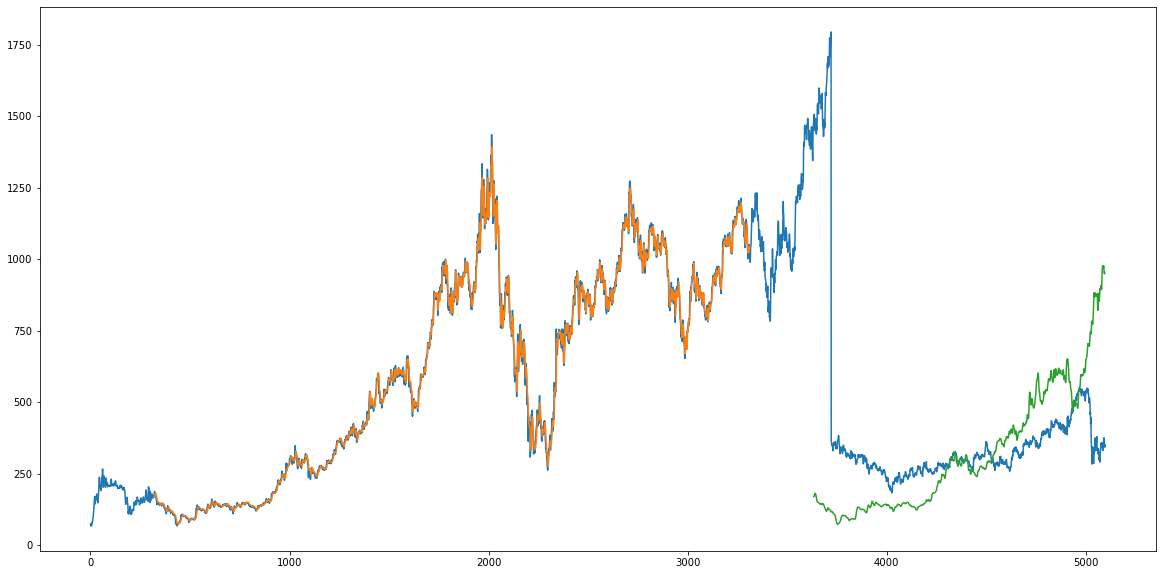

In [51]:
#Plotting the training and testing data
look_back= 320 #time stamp
#Training data
trainPredictPlot= np.empty_like(df1)
trainPredictPlot[:, :]= np.nan
trainPredictPlot[look_back: len(train_predict)+look_back, :]= train_predict

#Test Data
testPredictPlot= np.empty_like(df1)
testPredictPlot[:, :]= np.nan
testPredictPlot[len(train_predict)+(look_back*2) +1: len(df1) -1 , :]= test_predict

#Plotting the baseline and predictions

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [63]:
len(testData)

1784

In [ ]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape